# Sandbox

## Linear Regression

In [0]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg
from scipy.linalg import expm

def generate_problem(p, n):
  X = np.random.randn(n, p)
  
  # Model definition
  theta_clean = np.ones(p)
  y = X @ theta_clean + 5e-1*np.random.randn(n) # right-hand side
  theta_0 = np.random.randn(p)
  
  # A = X[:int(n/2), :].T @ X[:int(n/2), :]
  # B = X[int(n/2):, :].T @ X[int(n/2):, :]
  # com_norm = np.linalg.norm(A@B - B@A)
  # print('Commutator norm (2 batches) {:.3}'.format(com_norm))
  
  return X, theta_0, y

def loss(X, theta, y):
  n, p = X.shape
  return 1/n*np.linalg.norm(X @ theta - y)**2

def gradient(X, theta, y):
  n, p = X.shape
  return 1/n* X.T @ (X @ theta - y)

def make_SGD_step(X_batch, theta_0, y_batch, h):
  theta = theta_0 - h*gradient(X_batch, theta_0, y_batch)
  return theta

# def euler_local_problem(X_batch, theta_0, y_batch, h, N, N_precision = 1000):
#   p, batch_size = X_batch.shape
#   theta = theta_0
#   for i in range(N_precision):
#     theta = theta + h/N_precision*(-1/N* X_batch@(X_batch.T@theta - y_batch))
#     # print(np.linalg.norm(theta))
#   return theta

def solve_local_problem(X_batch, theta_0, y_batch, h, n):
  Q,R  = np.linalg.qr(X_batch.T)
  R_it = np.linalg.inv(R.T)
  return Q @ expm(-1/n* R @ R.T*h) @ (Q.T @ theta_0 - R_it @ y_batch ) + Q @ R_it @ y_batch + (np.eye(p) - Q @ Q.T) @ theta_0

In [0]:
# Splitting for LS
p = 200
n = 1000
N = 100
b = 10
n_epochs = 3

h = 100

X, theta_0, y = generate_problem(p,n)

Xs = np.zeros((N, b, p))
ys = np.zeros((N, b))

for i_batch in range(N):
  Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :] 
  ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
  
thetas = []
theta = theta_0
thetas.append(theta)
for epoch in range(n_epochs):
  for i in range(N):
    theta = solve_local_problem(Xs[i], theta, ys[i], h, n)
    thetas.append(theta)

residuals = [np.linalg.norm(theta - np.ones(p)) for theta in thetas]
plt.plot(residuals)
plt.title('LLS, X = ({}, {}), batch = {}, h = {}, epochs = {}'.format(p, n, b, h, n_epochs))
plt.xlabel('h')
plt.ylabel(r'$\|\theta - \theta_{GF}\|$')
plt.show()

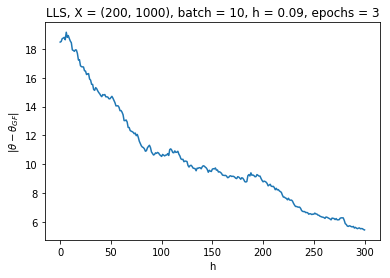

In [0]:
# SGD for LS
p = 200
n = 1000
N = 100
b = 10
n_epochs = 3

h = 0.09

X, theta_0, y = generate_problem(p,n)

Xs = np.zeros((N, b, p))
ys = np.zeros((N, b))

for i_batch in range(N):
  Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :] 
  ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
  
thetas = []
theta = theta_0
thetas.append(theta)
for epoch in range(n_epochs):
  for i in range(N):
    theta = make_SGD_step(Xs[i], theta, ys[i], h)
    thetas.append(theta)

residuals = [np.linalg.norm(theta - np.ones(p)) for theta in thetas]
plt.plot(residuals)
plt.title('LLS, X = ({}, {}), batch = {}, h = {}, epochs = {}'.format(p, n, b, h, n_epochs))
plt.xlabel('h')
plt.ylabel(r'$\|\theta - \theta_{GF}\|$')
plt.show()

In [0]:
# Splitting for LS
p = 200
n = 1000
N = 100
b = 10
n_epochs = 5

h = 1
for h in np.logspace(-3,4, 10):
  X, theta_0, y = generate_problem(p,n)

  Xs = np.zeros((N, b, p))
  ys = np.zeros((N, b))

  for i_batch in range(N):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :] 
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    
  thetas_spl = []
  theta = theta_0
  thetas_spl.append(theta)
  for epoch in range(n_epochs):
    for i in range(N):
      theta = solve_local_problem(Xs[i], theta, ys[i], h*N, n)
      thetas_spl.append(theta)

  residuals_spl = [np.linalg.norm(theta - np.ones(p)) for theta in thetas_spl]
  plt.figure(figsize=(12.0, 4.0))
  plt.suptitle('LLS, X = ({}, {}), batch = {}, h = {:.2}, epochs = {}'.format(p, n, b, h, n_epochs))
  plt.subplot(1, 2, 1)

  plt.semilogy(residuals_spl)
  plt.title('Splitting (exact local solution)')
  plt.xlabel('iteration')
  plt.ylabel(r'$\|\theta - \theta_{GF}\|$')

  thetas_sgd = []
  theta = theta_0
  thetas_sgd.append(theta)
  for epoch in range(n_epochs):
    for i in range(N):
      theta = make_SGD_step(Xs[i], theta, ys[i], h)
      thetas_sgd.append(theta)

  residuals_sgd = [np.linalg.norm(theta - np.ones(p)) for theta in thetas_sgd]
  plt.subplot(1, 2, 2)
  plt.semilogy(residuals_sgd)
  plt.title('SGD (Euler local solution)')
  plt.xlabel('iteration')
  plt.ylabel(r'$\|\theta - \theta_{GF}\|$')
  plt.savefig('sgd_split{:.2}.pdf'.format(h))
  plt.show()

In [0]:
# Time comparison
import time
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg
from scipy.linalg import expm, qr
import copy

def generate_problem(p, n):
    X = np.random.randn(n, p)

    # Model definition
    theta_clean = np.ones(p)
    y = X @ theta_clean + 5e-1*np.random.randn(n) # right-hand side
    theta_0 = np.random.randn(p)

    return X, theta_0, y

def solve_local_problem(X_batch, theta_0, y_batch, h, n):
    Q,R  = qr(X_batch.T, mode='economic')
    R_it = np.linalg.inv(R.T)
    exp_m = expm(-1/n* R @ R.T*h)
    old_information = [Q,R, R_it, exp_m]
    return Q @ ( exp_m @ (Q.T @ theta_0 - R_it @ y_batch )) + Q @ (R_it @ y_batch) + theta_0 - Q @ (Q.T @ theta_0)

def solve_local_problem(X_batch, theta_0, y_batch, h, n):
    Q,R  = qr(X_batch.T, mode='economic')
    R_it = np.linalg.inv(R.T)
    exp_m = expm(-1/n* R @ R.T*h)
    old_information = [Q,R, R_it, exp_m]
    return Q @ ( exp_m @ (Q.T @ theta_0 - R_it @ y_batch )) + Q @ (R_it @ y_batch) + theta_0 - Q @ (Q.T @ theta_0) 

def solve_local_problem_b_1(x, theta_0, y, h, n):
    x = x.T
    norm = x.T @ x
    return theta_0 + (1 - np.exp(-norm*h/n))*(y - x.T @ theta_0)/norm*x

def loss(X, theta, y):
    n, p = X.shape
    return 1/n*np.linalg.norm(X @ theta - y)**2

def gradient(X, theta, y):
    n, p = X.shape
    return 1/n* X.T @ (X @ theta - y)

def make_SGD_step(X_batch, theta_0, y_batch, h):
    theta = theta_0 - h*gradient(X_batch, theta_0, y_batch)
    return theta
epsilons = np.linspace(0.1, 1)
p = 20
n = 100
N = 100
b = 1
n_max_iter = 20000
h = 0.005


X, theta_0, y = generate_problem(p,n)

Xs = np.zeros((N, b, p))
ys = np.zeros((N, b))

for i_batch in range(N):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :] 
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]

def relative_error(theta):
    p = len(theta)
    return(np.linalg.norm(theta - np.ones(p))/np.linalg.norm(np.ones(p)))

times_spl = []
times_sgd = []
for epsilon in epsilons:
    # Splitting
    theta = copy.deepcopy(theta_0)
    n_iter = 0
    start_time = time.time()
    while relative_error(theta) > epsilon and n_iter <= n_max_iter:
        i = n_iter % N
        theta = solve_local_problem_b_1(Xs[i], theta, ys[i], h*N, n)
        n_iter += 1
    end_time = time.time()
    times_spl.append(end_time-start_time)

    if n_iter > n_max_iter:
        print('Limit of iteration is reached. Relative error {:.2f}'.format(relative_error(theta)))
    else:
        print('GGWP, splitting on {} with {} iters'.format(epsilon, n_iter))
    

    # SGD
    theta = copy.deepcopy(theta_0)
    n_iter = 0
    start_time = time.time()
    while relative_error(theta) > epsilon and n_iter <= n_max_iter:
        i = n_iter % N
        theta = make_SGD_step(Xs[i], theta, ys[i], h)
        n_iter += 1
    end_time = time.time()
    times_sgd.append(end_time-start_time)

    if n_iter > n_max_iter:
        print('Limit of iteration is reached. Relative error {:.2f}'.format(relative_error(theta)))
    else:
        print('GGWP, SGD on {} with {} iters'.format(epsilon, n_iter))
    

Limit of iteration is reached. Relative error 0.21
GGWP, SGD on 0.1 with 660 iters
Limit of iteration is reached. Relative error 0.21
GGWP, SGD on 0.11836734693877551 with 610 iters
Limit of iteration is reached. Relative error 0.21
GGWP, SGD on 0.13673469387755102 with 562 iters
Limit of iteration is reached. Relative error 0.21
GGWP, SGD on 0.15510204081632656 with 532 iters
Limit of iteration is reached. Relative error 0.21
GGWP, SGD on 0.17346938775510207 with 488 iters
Limit of iteration is reached. Relative error 0.21
GGWP, SGD on 0.19183673469387758 with 460 iters
GGWP, splitting on 0.21020408163265308 with 1676 iters
GGWP, SGD on 0.21020408163265308 with 440 iters
GGWP, splitting on 0.2285714285714286 with 1478 iters
GGWP, SGD on 0.2285714285714286 with 418 iters
GGWP, splitting on 0.2469387755102041 with 1378 iters
GGWP, SGD on 0.2469387755102041 with 388 iters
GGWP, splitting on 0.2653061224489796 with 1350 iters
GGWP, SGD on 0.2653061224489796 with 372 iters
GGWP, splitting 

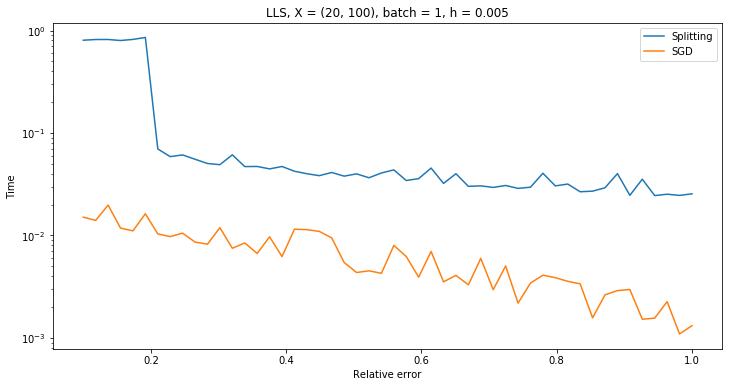

In [0]:
plt.figure(figsize=(12.0, 6.0))
plt.title('LLS, X = ({}, {}), batch = {}, h = {}'.format(p, n, b, h))
plt.semilogy(epsilons, times_spl, label = 'Splitting')
plt.semilogy(epsilons, times_sgd, label = 'SGD')
plt.xlabel('Relative error')
plt.ylabel('Time')
plt.legend()

plt.savefig('sgd_split_times{}.pdf'.format(h))
plt.show()

In [0]:
test = []
test.append(1,1,2)

TypeError: ignored

In [0]:
!pip install line_profiler
%load_ext line_profiler

     |████████████████████████████████| 92kB 10.0MB/s 
  Created wheel for line-profiler: filename=line_profiler-2.1.2-cp36-cp36m-linux_x86_64.whl size=180889 sha256=bbe7c096f421c491ddc1eb12a8620ef15e2cfdb51a0beddafd54b42255e6c9a2
  Stored in directory: /root/.cache/pip/wheels/05/7d/9b/aafbe8d78dc2b2c644d2efd2f060ab3258143860142575193a
Successfully built line-profiler


In [0]:
theta = copy.deepcopy(theta_0)
i = 0
%lprun -f make_SGD_step make_SGD_step(Xs[i], theta, ys[i], h)

In [0]:
theta = copy.deepcopy(theta_0)
i = 0
%lprun -f solve_local_problem solve_local_problem_b_1(Xs[i], theta, ys[i], h, n)

(2000, 1) (2000,) (1,)


## Logistic regression

0it [00:00, ?it/s]

9920512it [00:06, 1583666.98it/s]                             


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 142291.82it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2171052.87it/s]                            
0it [00:00, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 52928.56it/s]            


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


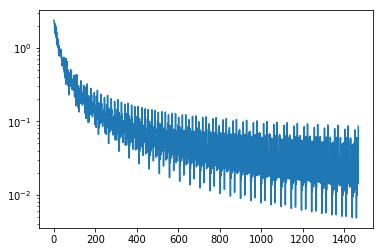

In [0]:
# Splitting

p = 784
n = 12665
b = 256
N = n//b
n_epochs = 30

h = 1

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torchvision.datasets as datasets
from scipy.integrate import odeint
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

def make_splitting_step(X, theta_0, y, h, n):
  h_seq = [0, h/4, h/2, 3*h/4, h]
  X, y = np.array(X), np.array(y)
  def rhs(theta, t):
    h_theta = [1/(1+np.exp(-theta.T @ x)) for x in X]
    return -1/n * X.T @ (h_theta - y)
  thetas = odeint(rhs, theta_0, h_seq)
  return thetas[-1]

def loss_logreg(X, theta, y):
  h_theta = [1/(1+np.exp(-theta.T @ x)) for x in X]
  y_true = y
  y_pred = h_theta
  return log_loss(y_true, y_pred)

def generate_problem_logistic_regression():
  trainset = datasets.MNIST('./mnist_data/', download=True, train=True)
  X_train = trainset.data.to(dtype=torch.float)/255
  y_train = trainset.targets
  X_train.resize_(len(X_train),  X_train[0].shape[0]*X_train[0].shape[1])
  y_train.view(-1).long()

  indicies0 = y_train == 0
  indicies1 = y_train == 1
  return X_train[indicies0 + indicies1], y_train[indicies0 + indicies1]

X, y = generate_problem_logistic_regression()
theta_0 = np.random.randn(p)

Xs = np.zeros((N, b, p))
ys = np.zeros((N, b))

for i_batch in range(N):
  Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
  ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
  
losses_spl = []

theta = theta_0
for epoch in range(n_epochs):
    for i_batch in range(N):
      X_batch = Xs[i_batch]
      y_batch = ys[i_batch]
     
      loss = loss_logreg(X_batch, theta, y_batch)
      losses_spl.append(loss)
      theta = make_splitting_step(X_batch, theta, y_batch, h, n)
      theta = np.squeeze(theta)

plt.semilogy(losses_spl)
plt.show()

12665


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


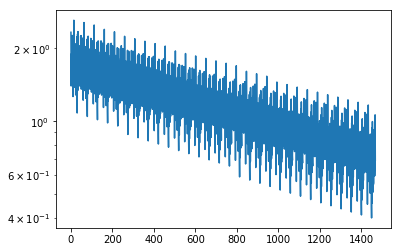

In [0]:
# SGD
p = 784
n = 12665
b = 256
N = n//b
n_epochs = 30

h = 0.001

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torchvision.datasets as datasets

def generate_problem_logistic_regression():
  trainset = datasets.MNIST('./mnist_data/', download=True, train=True)
  X_train = trainset.data.to(dtype=torch.float)/255
  y_train = trainset.targets
  X_train.resize_(len(X_train),  X_train[0].shape[0]*X_train[0].shape[1])
  y_train.view(-1).long()

  indicies0 = y_train == 0
  indicies1 = y_train == 1
  return X_train[indicies0 + indicies1], y_train[indicies0 + indicies1]

class LogisticRegression(torch.nn.Module):
     def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(p, 1)
     def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

model = LogisticRegression()
X, y = generate_problem_logistic_regression()
print(len(X))

Xs = torch.zeros((N, b, p))
ys = torch.zeros((N, b))

for i_batch in range(N):
  Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
  ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
  
criterion = nn.BCELoss()
losses_sgd = []

theta_0 = np.random.randn(p)
for parameter in model.parameters():
  parameter.data[0] = torch.from_numpy(theta_0)
  break

for epoch in range(n_epochs):
    model.train()
    for i_batch in range(N):
      X_batch = Xs[i_batch]
      y_batch = ys[i_batch]
      model.zero_grad()
      # Forward pass
      y_pred = model(X_batch)
      # Compute Loss
      loss = criterion(y_pred, y_batch)
      losses_sgd.append(loss.data)
      # Backward pass
      loss.backward()
      for parameter in model.parameters():
        parameter.data = parameter.data - h*parameter.grad.data

plt.semilogy(losses_sgd)
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


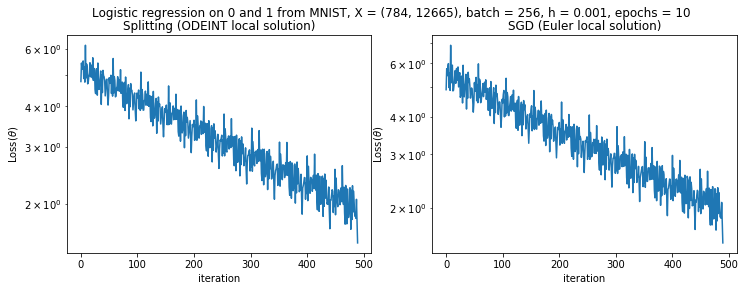

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


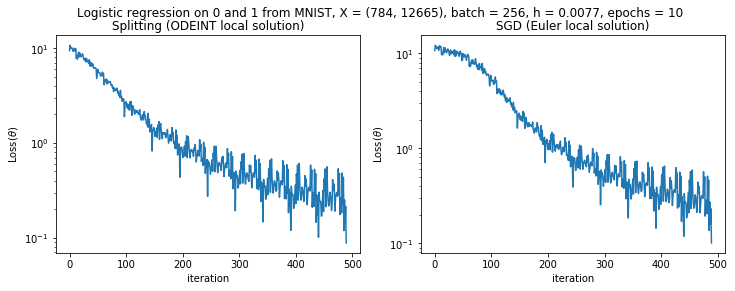

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


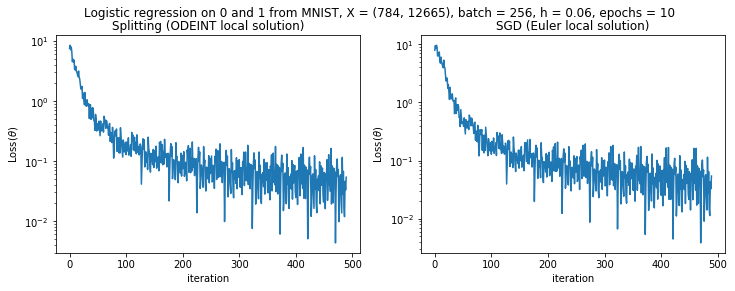

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


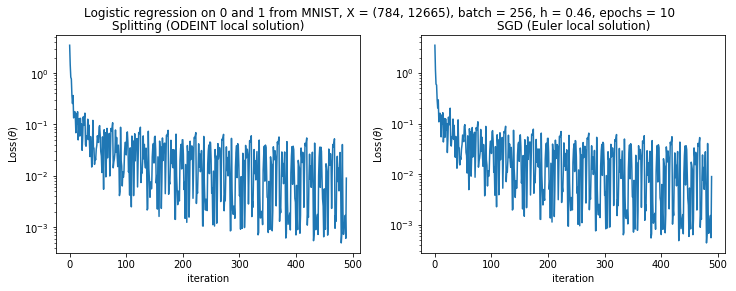

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


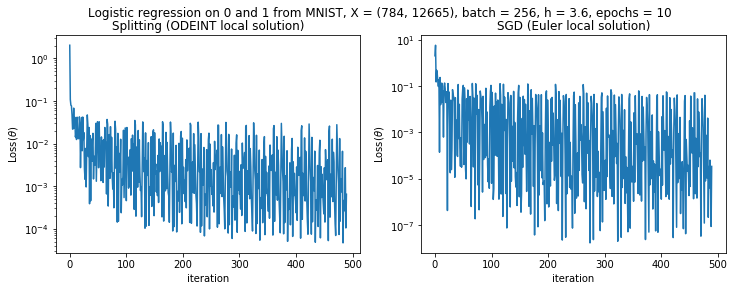

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


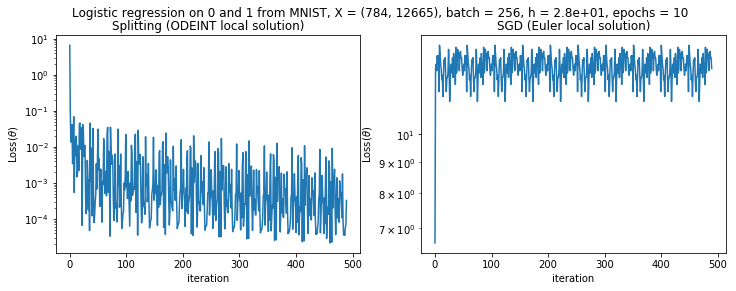

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


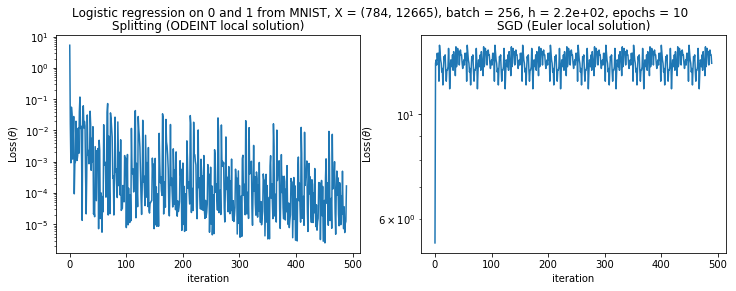

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


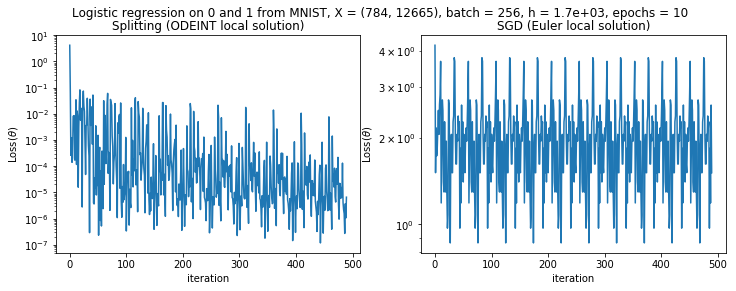

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


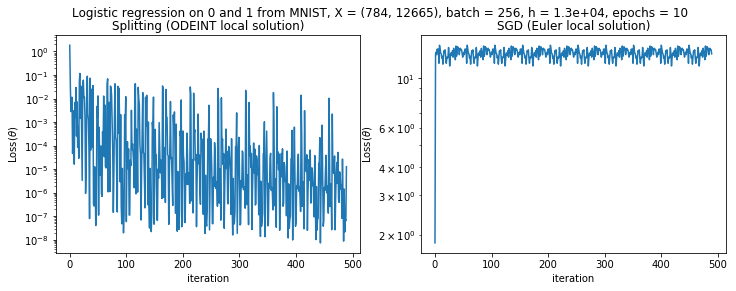

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


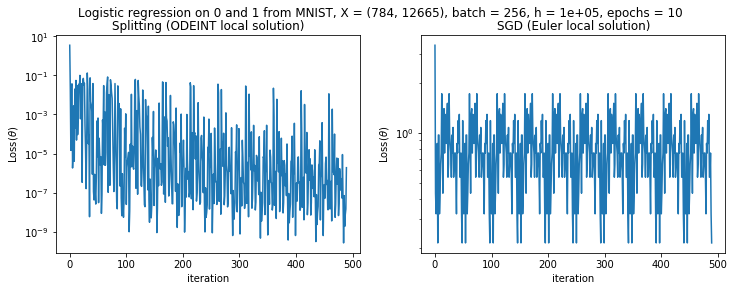

In [0]:
# Splitting and SGD for logistic regression
p = 784
n = 12665
b = 256
N = n//b
n_epochs = 10

for h in np.logspace(-3,5, 10):
  X, y = generate_problem_logistic_regression()
  theta_0 = np.random.randn(p)

  Xs = torch.zeros((N, b, p))
  ys = torch.zeros((N, b))

  for i_batch in range(N):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    
  model = LogisticRegression()
  for parameter in model.parameters():
    parameter.data[0] = torch.from_numpy(theta_0)
    break
  criterion = nn.BCELoss()
  losses_sgd = []

  for epoch in range(n_epochs):
      model.train()
      for i_batch in range(N):
        X_batch = Xs[i_batch]
        y_batch = ys[i_batch]
        model.zero_grad()
        # Forward pass
        y_pred = model(X_batch)
        # Compute Loss
        loss = criterion(y_pred, y_batch)
        losses_sgd.append(loss.data)
        # Backward pass
        loss.backward()
        for parameter in model.parameters():
          parameter.data = parameter.data - h*parameter.grad.data

  Xs = np.zeros((N, b, p))
  ys = np.zeros((N, b))

  for i_batch in range(N):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :] 
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
  losses_spl = []

  theta = theta_0
  for epoch in range(n_epochs):
      for i_batch in range(N):
        X_batch = Xs[i_batch]
        y_batch = ys[i_batch]
      
        loss = loss_logreg(X_batch, theta, y_batch)
        losses_spl.append(loss)
        theta = make_splitting_step(X_batch, theta, y_batch, h*N, n)
        theta = np.squeeze(theta)

  plt.figure(figsize=(12.0, 4.0))
  plt.suptitle('Logistic regression on 0 and 1 from MNIST, X = ({}, {}), batch = {}, h = {:.2}, epochs = {}'.format(p, n, b, h, n_epochs))
  plt.subplot(1, 2, 1)

  plt.semilogy(losses_spl)
  plt.title('Splitting (ODEINT local solution)')
  plt.xlabel('iteration')
  plt.ylabel(r'Loss$(\theta)$')

  plt.subplot(1, 2, 2)
  plt.semilogy(losses_sgd)
  plt.title('SGD (Euler local solution)')
  plt.xlabel('iteration')
  plt.ylabel(r'Loss$(\theta)$')
  plt.savefig('sgd_split_logreg{:.2}.pdf'.format(h))
  plt.show()

In [0]:
np.linalg.norm(theta - theta_0)

37.37806552606645

## Softmax regression

In [0]:
import torchvision.datasets as datasets
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import copy
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(int(input_dim), int(output_dim))
    def forward(self, x):
    	x = x.contiguous().view(x.size(0), -1)
    	out = F.softmax(self.linear(x), dim=1)
    	return out

def load_model(X_test, y_test):
	'''
	Returns logistic regression model
	Which is just single linear layer with flattening at the beginning and softmax at the end
	'''
	input_dim = X_test[0].numel()

	# Handling with usual and one-hot format
	if any(y_test > 1):
		output_dim = max(y_test) + 1
	else:
		output_dim = 2

	model = LogisticRegression(input_dim, output_dim)
	return model

def load_batched_data(batch_size=50, shuffle = True):
	'''
	Load batches of MNIST data.

	Output: X_trains - N_train batches of training data, 
			y_trains - N_train batches of labels,
			X_test - test points
			y_test - test labels
	X_trains: torch.array of shape (N_train,batch_size,*X_train[0].shape),
		where 
		N_train - the number of batches, 
		batch_size - batch size
		*X_train[0].shape - shape of the dataset point;

	y_trains: torch.array of shape (N_train,batch_size);

	X_test: torch.array of shape (s_test,*X_train[0].shape),
		where
		s_test - the number of test points;

	y_test: torch.array of shape (s_test);
	'''
	number_of_classes = 2
	trainset = datasets.MNIST('./mnist_data/', download=True, train=True)
	X_train = trainset.data.to(dtype=torch.float)/255
	y_train = trainset.targets
	mask    = y_train <= number_of_classes
	X_train = X_train[mask]
	y_train = y_train[mask]
	X_train.resize_(len(X_train), 1, *X_train[0].shape)
	y_train.view(-1).long()

	if shuffle == True:
		shuffling = torch.randperm(len(y_train))
		X_train = X_train[shuffling]
		y_train = y_train[shuffling]

	# Download and load the test data
	testset = datasets.MNIST('./mnist_data/', download=True, train=False)
	X_test = testset.data.to(dtype=torch.float)/255
	y_test = testset.targets
	mask   = y_test <= number_of_classes
	X_test = X_test[mask]
	y_test = y_test[mask]
	X_test.resize_(len(X_test), 1, *X_test[0].shape)
	y_test.view(-1).long()

	if shuffle == True:
		shuffling = torch.randperm(len(y_test))
		X_test = X_test[shuffling].to(device)
		y_test = y_test[shuffling]

	s_train = len(y_train)
	s_test  = len(y_test)

	N_train = int(s_train/batch_size)   # Number of training batches

	X_trains = torch.zeros((N_train,batch_size,*X_train[0].shape),requires_grad=False).to(device)
	y_trains = torch.zeros((N_train,batch_size),requires_grad=False, dtype=torch.int64).to(device)

	for i in range(N_train):
	    X_trains[i] = X_train[batch_size*i:batch_size*(i+1), :]
	    y_trains[i] = y_train[batch_size*i:batch_size*(i+1)]

	return X_trains, y_trains, X_test, y_test

def train_SGD(model, X_trains, y_trains, X_test, y_test, n_epochs, hs, weights_name = './'):
	model     = model.to(device)
	criterion = nn.CrossEntropyLoss()
	N_batches  = int(X_trains.size(0))
	batch_size = int(X_trains.size(1)) 

	history = {}  
	history['train_loss'] = np.zeros(n_epochs)
	history['test_loss']  = np.zeros(n_epochs)
	history['train_acc']  = np.zeros(n_epochs)
	history['test_acc']   = np.zeros(n_epochs)

	for epoch in tqdm(range(n_epochs)):
		#==== Forward steps  ====
		model.train()
		h = hs[epoch]
		for i_batch in range(N_batches):
			# Forward pass
			images, labels = X_trains[i_batch], y_trains[i_batch]
			images, labels = images.to(device), labels.to(device)
			predictions = model(images)
			loss = criterion(predictions, labels)

			# Gradient step
			model.zero_grad()
			loss.backward()
			# torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
			for idp, parameter in enumerate(model.parameters()):
				grad           = parameter.grad.data
				grad           = grad.to(device)
				parameter.data = parameter.data - h*grad

		# Metrics calculation
		history['train_loss'][epoch] = loss.data
		pred_label = torch.max(predictions, 1, keepdim=True)[1]
		history['train_acc'][epoch] = pred_label.eq(labels.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(labels)
		with torch.no_grad():
			model.eval()
			Xst = X_test.to(device)
			yst = y_test.to(device)
			predictions = model(Xst)
			loss = criterion(predictions, yst)
			history['test_loss'][epoch] = loss.data
			pred_label = torch.max(predictions, 1, keepdim=True)[1]
			history['test_acc'][epoch] = pred_label.eq(yst.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(yst)
	return history

def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)

def model_init(model, parameter_list):
	new_model = copy.deepcopy(model)
	for idp, parameter in enumerate(new_model.parameters()):
		parameter.data = torch.tensor(parameter_list[idp]).to(device)
	return new_model

def plot_history(history, title=''):
	fig = plt.figure(figsize = (16,9))
	fig.suptitle(title)
	plt.subplot(2, 2, 1)
	plt.xlabel('epoch')
	plt.ylabel('Train loss')
	plt.semilogy(history['train_loss'])

	plt.subplot(2, 2, 2)
	plt.xlabel('epoch')
	plt.ylabel('Train accuracy')
	plt.plot(history['train_acc'])

	plt.subplot(2, 2, 3)
	plt.xlabel('epoch')
	plt.ylabel('Test loss')
	plt.semilogy(history['test_loss'])

	plt.subplot(2, 2, 4)
	plt.xlabel('epoch')
	plt.ylabel('Test accuracy')
	plt.plot(history['test_acc'])

	# plt.savefig('MLP_optims.svg')
	plt.show()

In [0]:
### SGD
batch_size = 1
X_trains, y_trains, X_test, y_test = load_batched_data(batch_size=batch_size)
N_batches = int(len(y_trains)/batch_size)
model = load_model(X_test, y_test)
parameter_list = []
for parameter in model.parameters():
    parameter_list.append(parameter)

model = model_init(model, parameter_list)
n_epochs = 5
h = 0.001

hs = [h*N_batches for i in range(n_epochs)]
history = train_SGD(model, X_trains, y_trains, X_test, y_test, n_epochs, hs)


0it [00:00, ?it/s]

9920512it [00:01, 8898254.33it/s]                            


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 136701.99it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2259541.38it/s]                            
0it [00:00, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 51960.70it/s]            


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 5/5 [00:37<00:00,  7.41s/it]


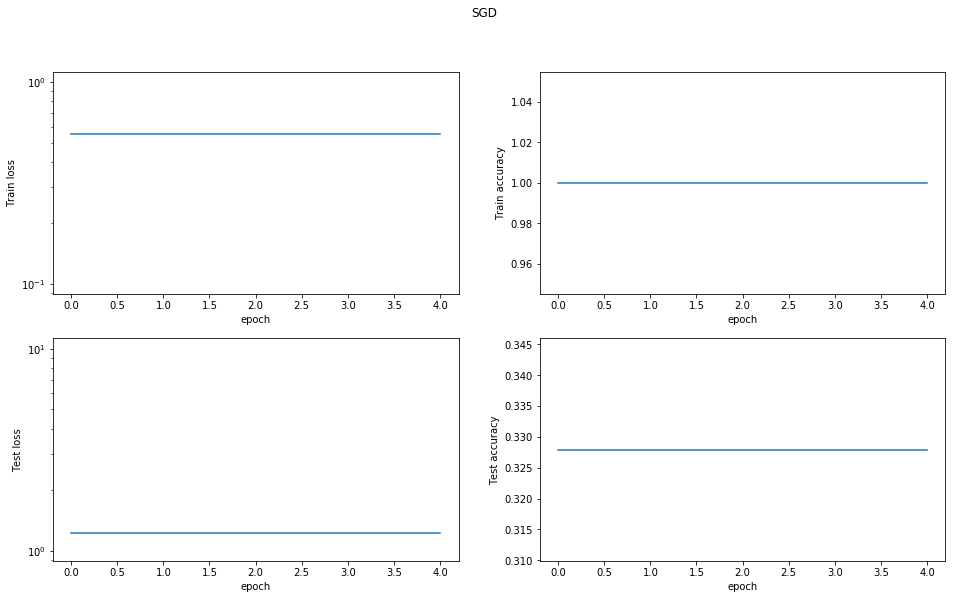

In [0]:
plot_history(history, title='SGD')

In [0]:
### ODEint
from scipy.integrate import odeint

def sigmoid(X_batch, thetas):
    if len(X_batch.shape) > 1:
        batch_size, p = X_batch.shape
    else:
        X_batch = np.expand_dims(X_batch, axis=0)
        batch_size, p = X_batch.shape
    K = len(thetas) - 1
    h = np.zeros((batch_size, K))
    theta_b = thetas[-1]
    for i_object in range(batch_size):
        x = X_batch[i_object]
        etas = [np.float(thetas[k] @ x + theta_b[k]) for k in range(K)]
        normalization = np.sum(np.exp(etas))
        h[i_object, :] = np.exp(etas)/normalization
    return h

def make_splitting_step(thetas_0, X_batchin, y_batch, n, h):
    X_batch = copy.deepcopy(X_batchin)
    X_batch, y_batch = np.array(X_batch.view(-1)), np.array(y_batch)
    # ONLY SINGULAR VECTOR IN A BATCH now
    if len(y_batch) > 1:
        print("For the moment, b should be equal to 1")
    thetas_final = []
    h_seq = [0, h]
    K = len(thetas_0) - 1
    # Q, R = np.linalg.qr(X_batch) in the future
    r = np.linalg.norm(X_batch)
    q = X_batch/r
    etas_0 = [q.T @ thetas_0[i] for i in range(K)]
    def rhs(etas, t, X_batch, y_batch, thetas, r, n):
        batch_size = len(y_batch)
        y_batch_one_hot = np.zeros((batch_size, K))
        y_batch_one_hot[np.arange(batch_size), y_batch] = 1
        etas    = np.array(etas)
        vector  = np.exp(etas*r)
        normalization = np.sum(vector)
        return np.squeeze(-1/n * r * (sigmoid(X_batch, thetas) - y_batch_one_hot))

    eta = odeint(rhs, etas_0, h_seq, args=(X_batch, y_batch, thetas_0, r, n))[-1]

    for i_parameter in range(K):
        theta_0 = thetas_0[i_parameter]
        eta_0 = etas_0[i_parameter]
        theta_final = q *(eta[i_parameter] - eta_0) + theta_0
        thetas_final.append(theta_final)
    theta_b_0 = thetas_0[-1]
    batch_size = len(y_batch)
    y_batch_one_hot = np.zeros((batch_size, K))
    y_batch_one_hot[np.arange(batch_size), y_batch] = 1
    theta_b = np.squeeze(theta_b_0 -1/n * (sigmoid(X_batch, thetas_0) - y_batch_one_hot)*h)
    thetas_final.append(theta_b)
    return thetas_final

def train_splitting(model, X_trains, y_trains, X_test, y_test, n_epochs, hs, weights_name = './'):
    model     = model.to(device)
    criterion = nn.CrossEntropyLoss()
    N_batches  = int(X_trains.size(0))
    batch_size = int(X_trains.size(1))
    K = np.amax(np.array(y_trains)) + 1
    print(type(K))
    p = np.array(X_test[0]).size
    n = N_batches*batch_size
    thetas = []
    parameter_list = []
    for parameter in model.parameters():
        parameter_list.append(parameter.data.numpy())
    thetas = [parameter_list[0][i_class] for i_class in range(K)]
    thetas.append(parameter_list[1])

    history = {}  
    history['train_loss'] = np.zeros(n_epochs)
    history['test_loss']  = np.zeros(n_epochs)
    history['train_acc']  = np.zeros(n_epochs)
    history['test_acc']   = np.zeros(n_epochs)

    for epoch in tqdm(range(n_epochs)):
        #==== Forward steps  ====
        model.train()
        h = hs[epoch]
        for i_batch in tqdm(range(N_batches)):
            # Forward pass
            images, labels = X_trains[i_batch], y_trains[i_batch]
            images, labels = images.to(device), labels.to(device)

            # Splitting step
            model.zero_grad()
            thetas = make_splitting_step(thetas, images, labels, n, h)         

        # Metrics calculation
        parameter_list = [thetas[:int(K)], thetas[-1]]
        model = model_init(model, parameter_list).float()
        predictions = model(images)
        loss = criterion(predictions, labels)
        history['train_loss'][epoch] = loss.data
        pred_label = torch.max(predictions, 1, keepdim=True)[1]
        history['train_acc'][epoch] = pred_label.eq(labels.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(labels)
        with torch.no_grad():
            model.eval()
            Xst = X_test.to(device)
            yst = y_test.to(device)
            predictions = model(Xst)
            loss = criterion(predictions, yst)
            history['test_loss'][epoch] = loss.data
            pred_label = torch.max(predictions, 1, keepdim=True)[1]
            history['test_acc'][epoch] = pred_label.eq(yst.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(yst)
    return history

In [0]:
### Splitting
batch_size = 1
X_trains, y_trains, X_test, y_test = load_batched_data(batch_size)

model = load_model(X_test, y_test)
parameter_list = []
for parameter in model.parameters():
    parameter_list.append(parameter)

model = model_init(model, parameter_list)
n_epochs = 5
h = 0.001
hs = [h for i in range(n_epochs)]
history = train_splitting(model, X_trains, y_trains, X_test, y_test, n_epochs, hs)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 6/18623 [00:00<06:00, 51.71it/s]

<class 'numpy.int64'>



 77%|███████▋  | 14267/18623 [04:39<01:26, 50.53it/s]

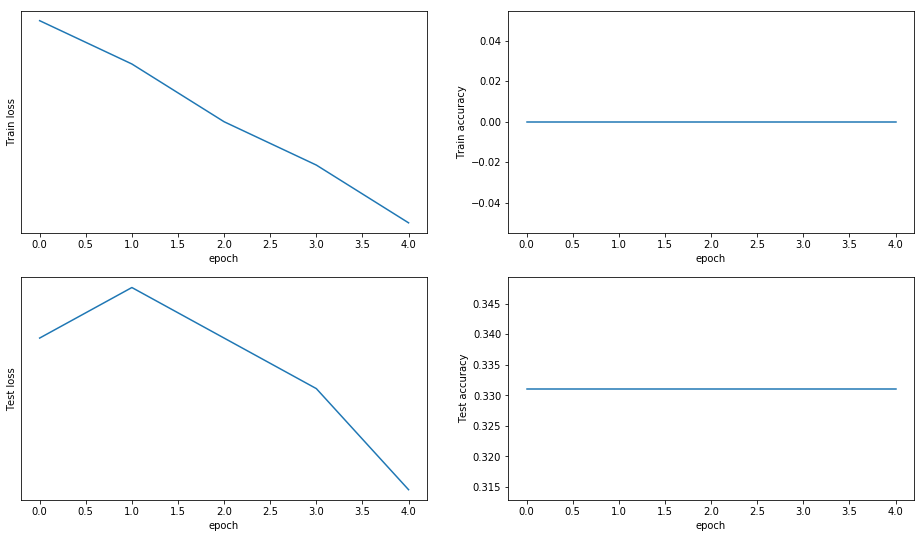

In [0]:
plot_history(history)

# [NEW] Softmax

In [0]:
# ======= Libraries =======

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torchvision.datasets as datasets
from scipy.integrate import odeint
from scipy.linalg import expm, qr
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

# ======= Function definitions =======
## ======= SPLITTING =======
def sigmoid(X_batch, thetas):
    if len(X_batch.shape) > 1:
        batch_size, p = X_batch.shape
    else:
        X_batch = np.expand_dims(X_batch, axis=0)
        batch_size, p = X_batch.shape
    K = len(thetas) - 1
    h = np.zeros((batch_size, K))
    theta_b = thetas[-1]
    for i_object in range(batch_size):
        x = X_batch[i_object]
        etas = [np.float(thetas[k] @ x + theta_b[k]) for k in range(K)]
        normalization = np.sum(np.exp(etas))
        h[i_object, :] = np.exp(etas)/normalization
    return h

def make_splitting_step(thetas_0, X_batchin, y_batch, n, h):
    X_batch = copy.deepcopy(X_batchin)
    X_batch, y_batch = np.array(X_batch.view(-1)), np.array(y_batch)
    # ONLY SINGULAR VECTOR IN A BATCH now
    if len(y_batch) > 1:
        print("For the moment, b should be equal to 1")
    thetas_final = []
    h_seq = [0, h]
    K = len(thetas_0) - 1
    # Q, R = np.linalg.qr(X_batch) in the future
    r = np.linalg.norm(X_batch)
    q = X_batch/r
    etas_0 = [q.T @ thetas_0[i] for i in range(K)]
    def rhs(etas, t, X_batch, y_batch, thetas, r, n):
        batch_size = len(y_batch)
        y_batch_one_hot = np.zeros((batch_size, K))
        y_batch_one_hot[np.arange(batch_size), y_batch] = 1
        etas    = np.array(etas)
        vector  = np.exp(etas*r)
        normalization = np.sum(vector)
        return np.squeeze(-1/n * r * (sigmoid(X_batch, thetas) - y_batch_one_hot))

    eta = odeint(rhs, etas_0, h_seq, args=(X_batch, y_batch, thetas_0, r, n))[-1]

    for i_parameter in range(K):
        theta_0 = thetas_0[i_parameter]
        eta_0 = etas_0[i_parameter]
        theta_final = q *(eta[i_parameter] - eta_0) + theta_0
        thetas_final.append(theta_final)
    theta_b_0 = thetas_0[-1]
    batch_size = len(y_batch)
    y_batch_one_hot = np.zeros((batch_size, K))
    y_batch_one_hot[np.arange(batch_size), y_batch] = 1
    theta_b = np.squeeze(theta_b_0 -1/n * (sigmoid(X_batch, thetas_0) - y_batch_one_hot)*h)
    thetas_final.append(theta_b)
    return thetas_final

def train_splitting(model, X_trains, y_trains, X_test, y_test, n_epochs, hs, weights_name = './'):
    model     = model.to(device)
    criterion = nn.CrossEntropyLoss()
    N_batches  = int(X_trains.size(0))
    batch_size = int(X_trains.size(1))
    K = np.amax(np.array(y_trains)) + 1
    p = np.array(X_test[0]).size
    n = N_batches*batch_size
    thetas = []
    parameter_list = []
    for parameter in model.parameters():
        parameter_list.append(parameter.data.numpy())
    thetas = [parameter_list[0][i_class] for i_class in range(K)]
    thetas.append(parameter_list[1])

    history = {}  
    history['train_loss'] = np.zeros(n_epochs)
    history['test_loss']  = np.zeros(n_epochs)
    history['train_acc']  = np.zeros(n_epochs)
    history['test_acc']   = np.zeros(n_epochs)

    for epoch in tqdm(range(n_epochs)):
        #==== Forward steps  ====
        model.train()
        h = hs[epoch]
        for i_batch in tqdm(range(N_batches)):
            # Forward pass
            images, labels = X_trains[i_batch], y_trains[i_batch]
            images, labels = images.to(device), labels.to(device)

            # Splitting step
            model.zero_grad()
            thetas = make_splitting_step(thetas, images, labels, n, h)         

        # Metrics calculation
        parameter_list = [thetas[:int(K)], thetas[-1]]
        model = model_init(model, parameter_list).float()
        predictions = model(images)
        loss = criterion(predictions, labels)
        history['train_loss'][epoch] = loss.data
        pred_label = torch.max(predictions, 1, keepdim=True)[1]
        history['train_acc'][epoch] = pred_label.eq(labels.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(labels)
        with torch.no_grad():
            model.eval()
            Xst = X_test.to(device)
            yst = y_test.to(device)
            predictions = model(Xst)
            loss = criterion(predictions, yst)
            history['test_loss'][epoch] = loss.data
            pred_label = torch.max(predictions, 1, keepdim=True)[1]
            history['test_acc'][epoch] = pred_label.eq(yst.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(yst)
    return history

## ======= SGD =======

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(int(input_dim), int(output_dim))
    def forward(self, x):
    	x = x.contiguous().view(x.size(0), -1)
    	out = F.softmax(self.linear(x), dim=1)
    	return out

def load_model(X_test, y_test):
	'''
	Returns logistic regression model
	Which is just single linear layer with flattening at the beginning and softmax at the end
	'''
	input_dim = X_test[0].numel()

	# Handling with usual and one-hot format
	if any(y_test > 1):
		output_dim = max(y_test) + 1
	else:
		output_dim = 2

	model = LogisticRegression(input_dim, output_dim)
	return model

def load_batched_data(batch_size=50, shuffle = True, qr_mode = false):
	'''
	Load batches of MNIST data.

	Output: X_trains - N_train batches of training data, 
			y_trains - N_train batches of labels,
			X_test - test points
			y_test - test labels
	X_trains: torch.array of shape (N_train,batch_size,*X_train[0].shape),
		where 
		N_train - the number of batches, 
		batch_size - batch size
		*X_train[0].shape - shape of the dataset point;

	y_trains: torch.array of shape (N_train,batch_size);

	X_test: torch.array of shape (s_test,*X_train[0].shape),
		where
		s_test - the number of test points;

	y_test: torch.array of shape (s_test);
	'''
	number_of_classes = 2
	trainset = datasets.MNIST('./mnist_data/', download=True, train=True)
	X_train = trainset.data.to(dtype=torch.float)/255
	y_train = trainset.targets
	mask    = y_train <= number_of_classes
	X_train = X_train[mask]
	y_train = y_train[mask]
	X_train.resize_(len(X_train), 1, *X_train[0].shape)
	y_train.view(-1).long()

	if shuffle == True:
		shuffling = torch.randperm(len(y_train))
		X_train = X_train[shuffling]
		y_train = y_train[shuffling]

	# Download and load the test data
	testset = datasets.MNIST('./mnist_data/', download=True, train=False)
	X_test = testset.data.to(dtype=torch.float)/255
	y_test = testset.targets
	mask   = y_test <= number_of_classes
	X_test = X_test[mask]
	y_test = y_test[mask]
	X_test.resize_(len(X_test), 1, *X_test[0].shape)
	y_test.view(-1).long()

	if shuffle == True:
		shuffling = torch.randperm(len(y_test))
		X_test = X_test[shuffling].to(device)
		y_test = y_test[shuffling]

	s_train = len(y_train)
	s_test  = len(y_test)

	N_train = int(s_train/batch_size)   # Number of training batches

	X_trains    = torch.zeros((N_train, batch_size, *X_train[0].shape), requires_grad=False).to(device)
	y_trains    = torch.zeros((N_train, batch_size), requires_grad=False, dtype=torch.int64).to(device)
    if qr_mode:
        Qs      = torch.zeros((N_train, *X_train[0].shape, batch_size), requires_grad=False).to(device)
        Rs      = torch.zeros((N_train, batch_size, batch_size), requires_grad=False).to(device)

	for i in range(N_train):
	    X_trains[i] = X_train[batch_size*i:batch_size*(i+1), :]
	    y_trains[i] = y_train[batch_size*i:batch_size*(i+1)]
        if qr_mode:
            Qs[i], Rs[i] = qr(X_trains[i].T, mode='economic')

    if qr_mode:
        return X_trains, y_trains, X_test, y_test, Qs, Rs
    else:
        return X_trains, y_trains, X_test, y_test

def loss_moving_average(loss, window=50):
    if loss == []:
        return 1000
    else:
        return(np.average(loss[-window:]))

def train_SGD(model, X_trains, y_trains, X_test, y_test, n_epochs, hs, weights_name = './'):
	model     = model.to(device)
	criterion = nn.CrossEntropyLoss()
	N_batches  = int(X_trains.size(0))
	batch_size = int(X_trains.size(1)) 

	history = {}  
	history['train_loss'] = np.zeros(n_epochs)
	history['test_loss']  = np.zeros(n_epochs)
	history['train_acc']  = np.zeros(n_epochs)
	history['test_acc']   = np.zeros(n_epochs)

	for epoch in tqdm(range(n_epochs)):
		#==== Forward steps  ====
		model.train()
		h = hs[epoch]
		for i_batch in range(N_batches):
			# Forward pass
			images, labels = X_trains[i_batch], y_trains[i_batch]
			images, labels = images.to(device), labels.to(device)
			predictions = model(images)
			loss = criterion(predictions, labels)

			# Gradient step
			model.zero_grad()
			loss.backward()
			for idp, parameter in enumerate(model.parameters()):
				grad           = parameter.grad.data
				grad           = grad.to(device)
				parameter.data = parameter.data - h*grad

		# Metrics calculation
		history['train_loss'][epoch] = loss.data
		pred_label = torch.max(predictions, 1, keepdim=True)[1]
		history['train_acc'][epoch] = pred_label.eq(labels.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(labels)
		with torch.no_grad():
			model.eval()
			Xst = X_test.to(device)
			yst = y_test.to(device)
			predictions = model(Xst)
			loss = criterion(predictions, yst)
			history['test_loss'][epoch] = loss.data
			pred_label = torch.max(predictions, 1, keepdim=True)[1]
			history['test_acc'][epoch] = pred_label.eq(yst.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(yst)
	return history

# ======= Problem generation =======

batch_size = 32
X_trains, y_trains, X_test, y_test = load_batched_data(batch_size=batch_size)
print('🐱Data loaded')

N_batches = int(len(y_trains)/batch_size)
n_epochs = 5
h = 0.001
hs = [h*N_batches for i in range(n_epochs)]
model = load_model(X_test, y_test)
print('🐱Model loaded')

parameter_list = []
for parameter in model.parameters():
    parameter_list.append(parameter)

model = model_init(model, parameter_list)
print('🐱Model Initialized')



p = 784
n = len(X_train)
b = 32
N = n//b
n_max_iter = 3000
n_experiments = 30

epsilon = 0.3
hs = np.logspace(-3, 3.5, 12)

X, y = generate_problem_logistic_regression()
print('Data loaded')
theta_0 = np.random.randn(p)

model = LogisticRegression()
criterion = nn.BCELoss()
print('Model loaded')

Xs = np.zeros((N, b, p))
ys = np.zeros((N, b))
Qs = np.zeros((N, p, b))
Rs = np.zeros((N, b, b))

for i_batch in range(N):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    Qs[i_batch], Rs[i_batch] = qr(Xs[i_batch].T, mode='economic')

print('QR finished')
# ======= Solving problem =======
steps_spl_meta = np.zeros((n_experiments, len(hs)))
steps_sgd_meta = np.zeros((n_experiments, len(hs)))
times_spl_meta = np.zeros((n_experiments, len(hs)))
times_sgd_meta = np.zeros((n_experiments, len(hs)))

for experiment in range(n_experiments):
    print('💩 Experiment {}'.format(experiment))
    theta_0 = np.random.randn(p)
    model = LogisticRegression()
    criterion = nn.BCELoss()
    steps_spl = []
    steps_sgd = []
    times_spl = []
    times_sgd = []
    for h in hs:
        losss_spl = []
        losss_sgd = []
        # Splitting
        theta = copy.deepcopy(theta_0)
        n_iter = 0
        start_time = time.time()
        while loss_moving_average(losss_spl) > epsilon and n_iter <= n_max_iter:
            i = n_iter % N
            X_batch = Xs[i]
            y_batch = ys[i]
            loss = loss_logreg(X_batch, theta, y_batch)
            losss_spl.append(loss)

            theta = make_splitting_step(Qs[i], Rs[i], theta, y_batch, h*N, n)
            theta = np.squeeze(theta)
            n_iter += 1
        end_time = time.time()
        times_spl.append(end_time-start_time)
        steps_spl.append(n_iter)

        if n_iter > n_max_iter:
            print('Limit of iteration is reached. Average loss {:.2f}'.format(loss_moving_average(losss_spl)))
        else:
            print('GGWP, splitting on {} with {} iters'.format(h, n_iter))
        
        # SGD
        theta = copy.deepcopy(theta_0)
        model.train()
        for parameter in model.parameters():
            parameter.data[0] = torch.from_numpy(theta)
            break
        n_iter = 0
        start_time = time.time()
        while loss_moving_average(losss_sgd) > epsilon and n_iter <= n_max_iter:
            i = n_iter % N
            X_batch = torch.from_numpy(Xs[i]).float()
            y_batch = torch.from_numpy(ys[i]).float()
            model.zero_grad()
            # Forward pass
            y_pred = model(X_batch)
            # Compute Loss
            loss = criterion(y_pred.view(-1), y_batch.view(-1))
            losss_sgd.append(loss.data)
            # Backward pass
            loss.backward()
            for parameter in model.parameters():
                parameter.data = parameter.data - h*parameter.grad.data
            if loss_moving_average(losss_sgd) == float('Inf'):
                n_iter = n_max_iter
            n_iter += 1
            # print(loss_moving_average(losss_sgd))
        end_time = time.time()
        times_sgd.append(end_time-start_time)
        if n_iter == n_max_iter+1:
            times_sgd[-1] = 1  
        steps_sgd.append(n_iter)

        if n_iter > n_max_iter:
            print('Limit of iteration is reached. Average loss {:.2f}'.format(loss_moving_average(losss_sgd)))
        else:
            print('GGWP, SGD on {} with {} iters'.format(h, n_iter))
    steps_spl_meta[experiment, :] = steps_spl
    steps_sgd_meta[experiment, :] = steps_sgd
    times_spl_meta[experiment, :] = times_spl
    times_sgd_meta[experiment, :] = times_sgd